In [2]:
# ! pip install ucimlrepo

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from abc import ABC, abstractmethod
from copy import deepcopy

# Implementation 

In [3]:
class Initialization(ABC):
    @abstractmethod
    def initialize(self, n_output: int, n_input: int):
        pass


class NormalXavier(Initialization):
    def initialize(self, n_output: int, n_input: int):
        std = np.sqrt(2 / (n_output + n_input))
        return np.random.normal(0, std, (n_output, n_input)) * 10


class UniformXavier(Initialization):
    def initialize(self, n_output: int, n_input: int):
        val = np.sqrt(6 / (n_output + n_input))
        return np.random.uniform(-val, val, (n_output, n_input)) * 10


class He(Initialization):
    def initialize(self, n_output: int, n_input: int):
        return np.random.normal(0, np.sqrt(2 / n_output), (n_output, n_input)) * 10


class Zero(Initialization):
    def initialize(self, n_output: int, n_input: int):
        return np.zeros((n_output, n_input))


class Normal(Initialization):
    def initialize(self, n_output: int, n_input: int):
        return np.random.normal(0, 1, (n_output, n_input)) * 10


class Uniform_minus_one_one(Initialization):
    def initialize(self, n_output: int, n_input: int):
        return np.random.uniform(-1, 1, (n_output, n_input)) * 10


class Uniform_zero_one(Initialization):
    def initialize(self, n_output: int, n_input: int):
        return np.random.uniform(0, 1, (n_output, n_input)) * 10


class InitializationBuilder:
    @staticmethod
    def get_initialization(initialization: str, nodes_out: int, nodes_in: int):
        if initialization == "he":
            return He().initialize(nodes_out, nodes_in)
        elif initialization == "normal":
            return Normal().initialize(nodes_out, nodes_in)
        elif initialization == "normal_xavier":
            return NormalXavier().initialize(nodes_out, nodes_in)
        elif initialization == "uniform_xavier":
            return UniformXavier().initialize(nodes_out, nodes_in)
        elif initialization == "uniform_minus_one_one":
            return Uniform_minus_one_one().initialize(nodes_out, nodes_in)
        elif initialization == "uniform_zero_one":
            return Uniform_zero_one().initialize(nodes_out, nodes_in)
        elif initialization == "zero":
            return Zero().initialize(nodes_out, nodes_in)
        else:
            raise ValueError(f"Initialization function {initialization} not supported")

In [4]:
class Activation(ABC):
    @abstractmethod
    def activation(self, x: np.double) -> np.double:
        pass


class Sigmoid(Activation):
    def activation(self, x: np.double) -> np.double:
        return 1 / (1 + np.exp(-x))


class ReLU(Activation):
    def activation(self, x: np.double) -> np.double:
        return np.maximum(0, x)


class Tanh(Activation):
    def activation(self, x: np.double) -> np.double:
        return np.tanh(x)


class Softmax(Activation):
    """
    Softmax function is used in the output layer of a neural network for multi-class classification problems.
    It squashes the output of each unit to be between 0 and 1, just like a sigmoid function.
    It also divides each output such that the total sum of the outputs is equal to 1.
    """

    def activation(self, x: np.double) -> np.double:
        if x.ndim == 1:
            exps = np.exp(x - np.max(x))
            return exps / np.sum(exps)
        exps = np.exp(x - x.max(axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)


class Linear(Activation):
    def activation(self, x: np.double) -> np.double:
        return x


class LeakyReLU(Activation):
    def activation(self, x: np.double) -> np.double:
        return np.maximum(0.01 * x, x)


class ActivationBuilder:
    @staticmethod
    def get_activation(activation: str):
        if activation == "sigmoid":
            return Sigmoid()
        elif activation == "relu":
            return ReLU()
        elif activation == "tanh":
            return Tanh()
        elif activation == "softmax":
            return Softmax()
        elif activation == "linear":
            return Linear()
        elif activation == "leaky_relu":
            return LeakyReLU()
        else:
            raise ValueError(f"Activation function {activation} not supported")

In [5]:
class CostFunction(ABC):
    @abstractmethod
    def cost(self, y, y_hat):
        pass


class MeanSquaredError(CostFunction):
    def cost(self, y_hat: np.ndarray, y: np.ndarray) -> float:
        if isinstance(y, pd.Series) or isinstance(y, pd.DataFrame):
            y = y.to_numpy()
            if len(y.shape) == 1:
                y = y.reshape(-1, 1)
        return np.mean((y - y_hat) ** 2)


class AbsoluteError(CostFunction):
    def cost(self, y_hat: np.ndarray, y: np.ndarray) -> float:
        if isinstance(y, pd.Series) or isinstance(y, pd.DataFrame):
            y = y.to_numpy()
            if len(y.shape) == 1:
                y = y.reshape(-1, 1)
        return np.mean(np.abs(y - y_hat))


class CrossEntropyWithSoftmax(CostFunction):
    EPSILON = 1e-10

    def cost(self, y_hat: np.ndarray, y: np.ndarray) -> float:
        y_hat = np.clip(y_hat, self.EPSILON, 1)
        return -np.mean(y * np.log(y_hat))


class CostFunctionBuilder:
    def build_cost_function(self, cost_function: str):
        if cost_function == "mse":
            return MeanSquaredError()
        elif cost_function == "ae":
            return AbsoluteError()
        elif cost_function == "cross_entropy_with_softmax":
            return CrossEntropyWithSoftmax()
        else:
            raise ValueError("Invalid cost function")

In [6]:
class Layer:
    __slots__ = [
        "nodes_in",
        "nodes_out",
        "weights",
        "biases",
        "activation",
        "a",
        "z",
    ]

    def __init__(
        self,
        nodes_in,
        nodes_out,
        activation="sigmoid",
        weight_initialization="he",
        bias_initialization="zero",
    ):

        self.nodes_in = nodes_in
        self.nodes_out = nodes_out

        self.weights = InitializationBuilder.get_initialization(
            weight_initialization, nodes_out, nodes_in
        )

        self.biases = InitializationBuilder.get_initialization(
            bias_initialization, nodes_out, 1
        )
        self.activation = ActivationBuilder.get_activation(activation)

    def forward(self, a):
        self.z = np.dot(self.weights, a) + self.biases
        self.a = self.activation.activation(self.z)
        return self.a

In [7]:
class NeuralNetwork:
    __slots__ = [
        "layers",
        "optimizer",
        "cost_function",
        "layer_sizes",
    ]

    def __init__(
        self,
        cost_function="mse",
    ):
        self.layers = []
        self.layer_sizes = []
        self.cost_function = CostFunctionBuilder().build_cost_function(cost_function)

    def add_layer(self, layer: Layer):
        if not self.layer_sizes:
            self.layer_sizes = [layer.nodes_in]
        else:
            assert (
                layer.nodes_in == self.layer_sizes[-1]
            ), f"Output in previous layer doesn't match input in this layer"
        self.layer_sizes.append(layer.nodes_out)
        self.layers.append(layer)

    def _forward(self, x: np.ndarray):
        if isinstance(x, pd.DataFrame) or isinstance(x, pd.Series):
            x = x.to_numpy()
            if len(x.shape) == 1:
                x = x.reshape(-1, 1)
        a = x.T
        for layer in self.layers:
            a = layer.forward(a)
        return a

    def predict(self, x: np.ndarray):
        return self._forward(x).T

    def predict_class(self, x: np.ndarray):
        return np.argmax(self.predict(x), axis=1, keepdims=True)

    def flatten_weights_and_biases(self):
        weights_and_biases = []
        for layer in self.layers:
            weights_and_biases.append(layer.weights.flatten())
            weights_and_biases.append(layer.biases.flatten())
        return np.concatenate(weights_and_biases)

    def deflatten_weights_and_biases(self, solution):
        for layer in self.layers:
            layer.weights = solution[: layer.weights.size].reshape(layer.weights.shape)
            solution = solution[layer.weights.size :]
            layer.biases = solution[: layer.biases.size].reshape(layer.biases.shape)
            solution = solution[layer.biases.size :]

    def calculate_cost(self, x: np.ndarray, y: np.ndarray):
        base_cost = self.cost_function.cost(self.predict(x), y)
        return base_cost

### Proof that it works 

In [8]:
nn = NeuralNetwork(cost_function="mse")
nn.add_layer(Layer(2, 3, activation="relu"))
nn.add_layer(Layer(3, 3, activation="relu"))
nn.add_layer(Layer(3, 1, activation="sigmoid"))

# create dummy data
np.random.seed(42)
X = np.random.rand(100, 2)
y = np.random.randint(0, 2, (100, 1))

# train the model
nn.calculate_cost(X, y)

0.25

In [9]:
class Evolutionary_Algorithm:
    __slots__ = [
        "mutation_rate",
        "crossover_rate",
        "number_of_generations",
        "population_size",
        "population",
        "problem_dim",
        "hall_of_fame",
        "mutation_variance",
        "times_since_last_improvement",
    ]

    def __init__(
        self,
        mutation_rate=0.7,
        crossover_rate=0.7,
        number_of_generations=50,
        population_size=100,
    ):
        self.population_size = population_size
        self.number_of_generations = number_of_generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.population = None
        self.problem_dim = None
        self.hall_of_fame = []
        self.mutation_variance = 3
        self.times_since_last_improvement = 0

    def _generate_population(
        self,
        network_shape,
        cost_function="mse",
        activation="sigmoid",
        last_activation="sigmoid",
    ):
        self.population = []
        for _ in range(self.population_size):
            nn = NeuralNetwork(cost_function=cost_function)
            for input_size, output_size in zip(network_shape[:-1], network_shape[1:-1]):
                nn.add_layer(Layer(input_size, output_size, activation=activation))
            nn.add_layer(
                Layer(network_shape[-2], network_shape[-1], activation=last_activation)
            )
            self.population.append(nn)

        self.problem_dim = sum(
            [
                layer.nodes_in * layer.nodes_out + layer.nodes_out
                for layer in self.population[0].layers
            ]
        )

    def _mutation(self, individual):
        new_individual = deepcopy(individual)
        if np.random.rand() < self.mutation_rate:
            weights_and_biases = new_individual.flatten_weights_and_biases()
            weights_and_biases += np.random.normal(
                0, self.mutation_variance, self.problem_dim
            )
            new_individual.deflatten_weights_and_biases(weights_and_biases)
        return new_individual

    def _crossover(self, parent1, parent2):
        if np.random.rand() < self.crossover_rate:
            crossover_point = np.random.randint(1, self.problem_dim - 1)
            child1 = deepcopy(parent1)
            child2 = deepcopy(parent2)
            weights_and_biases_child1 = child1.flatten_weights_and_biases().copy()
            weights_and_biases_child2 = child2.flatten_weights_and_biases().copy()

            child1.deflatten_weights_and_biases(
                np.concatenate(
                    (
                        weights_and_biases_child1[:crossover_point],
                        weights_and_biases_child2[crossover_point:],
                    )
                )
            )
            child2.deflatten_weights_and_biases(
                np.concatenate(
                    (
                        weights_and_biases_child2[:crossover_point],
                        weights_and_biases_child1[crossover_point:],
                    )
                )
            )
            return child1, child2
        return parent1, parent2

    def _evaluate_population(self, x, y):
        fitness = np.zeros(len(self.population))
        for i, individual in enumerate(self.population):
            fitness[i] = individual.calculate_cost(x, y)
        self.hall_of_fame.append(np.argsort(fitness)[: int(self.population_size * 0.1)])
        return fitness

    def _tournament_selection(self, fitness):
        fitness = 1 / fitness
        # probabilities = fitness / np.sum(fitness)
        # indices = np.random.choice(
        #     range(len(self.population)),
        #     p=probabilities,
        #     size=self.population_size - 1,  # - len(self.hall_of_fame[-1]),
        #     replace=True,
        # )
        # select best individual to next population with the highest fitness
        indices = np.argsort(fitness)[: self.population_size - 1]
        return [self.population[i] for i in indices]

    def _select_individual(self, n=1):
        indices = np.random.choice(range(self.population_size), size=n, replace=False)
        return [self.population[i] for i in indices]

    def _visualize_individual(self, individual, x, y):
        y_pred = individual.predict(x)
        plt.scatter(x, y_pred, c="red")
        plt.scatter(x, y, c="blue")
        plt.legend(["Prediction", "True"])
        plt.show()

    def optimize(self, x, y, architecture, silent=False):
        # initialize the population
        self._generate_population(architecture)
        best_evaluation_in_iteration = []
        best_solution_in_iteration = []

        # main algorithm loop
        for generation in range(self.number_of_generations):

            # crossover
            children = [None] * self.population_size
            for i in range(0, self.population_size, 2):
                parent1, parent2 = self._select_individual(n=2)
                children[i], children[i + 1] = self._crossover(parent1, parent2)
            self.population += children

            # mutation
            # we mutate every individual in the population not random one
            mutated = [None] * self.population_size
            for i in range(self.population_size):
                individual = self._select_individual()[0]
                mutated[i] = self._mutation(individual)
            self.population = self.population + mutated

            # evaluate the population and log the best solution
            fitness = self._evaluate_population(x, y)
            if not silent:
                print(
                    f"iter: {generation}, best: {np.min(fitness)}, mutation: {self.mutation_variance}"
                )

            best_evaluation_in_iteration.append(np.min(fitness))
            # best_solution_in_iteration.append(self.population[self.hall_of_fame[-1][0]])
            best_solution_in_iteration.append(self.population[np.argmin(fitness)])
            if (
                generation > 0
                and best_evaluation_in_iteration[-1] == best_evaluation_in_iteration[-2]
            ):
                self.times_since_last_improvement += 1
            else:
                self.times_since_last_improvement = 0
            if self.times_since_last_improvement > 15:
                self.mutation_variance *= 1.1
                self.times_since_last_improvement = 0

            # create new population
            self.population = self._tournament_selection(fitness) + [
                self.population[self.hall_of_fame[-1][0]]
            ]
            # + self.population[
            #     self.hall_of_fame[-1]
            # ]

        return best_evaluation_in_iteration, best_solution_in_iteration

# Testing methods 

### MPG

In [10]:
# fetch dataset
auto_mpg = fetch_ucirepo(id=9)

# data (as pandas dataframes)
X = auto_mpg.data.features
y = auto_mpg.data.targets

### Iris

In [11]:
# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
X = iris.data.features
y = iris.data.targets

### Multimodal large

In [12]:
multimodal_large_train = pd.read_csv(
    "https://raw.githubusercontent.com/nizwant/miowid/main/data/regression/multimodal-large-training.csv"
)
multimodal_large_test = pd.read_csv(
    "https://raw.githubusercontent.com/nizwant/miowid/main/data/regression/multimodal-large-test.csv",
)

In [13]:
mean = multimodal_large_train.mean()
std = multimodal_large_train.std()
multimodal_large_train = (multimodal_large_train - mean) / std
multimodal_large_test = (multimodal_large_test - mean) / std

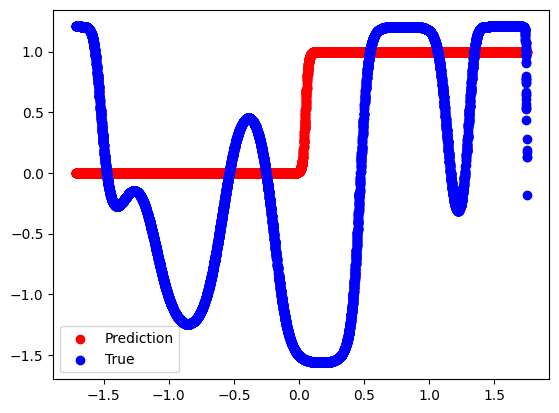

iter: 0, best: 0.6716188033957933, mutation: 3
iter: 1, best: 0.6716188033957933, mutation: 3
iter: 2, best: 0.6277796752691295, mutation: 3
iter: 3, best: 0.6277796752691295, mutation: 3
iter: 4, best: 0.6277796752691295, mutation: 3
iter: 5, best: 0.6277796752691295, mutation: 3
iter: 6, best: 0.6277796752691295, mutation: 3
iter: 7, best: 0.6277796752691295, mutation: 3
iter: 8, best: 0.6277796752691295, mutation: 3
iter: 9, best: 0.6277796752691295, mutation: 3
iter: 10, best: 0.6277796752691295, mutation: 3
iter: 11, best: 0.6277796752691295, mutation: 3
iter: 12, best: 0.6277796752691295, mutation: 3
iter: 13, best: 0.6277796752691295, mutation: 3
iter: 14, best: 0.6277796752691295, mutation: 3
iter: 15, best: 0.6277796752691295, mutation: 3
iter: 16, best: 0.6277796752691295, mutation: 3
iter: 17, best: 0.6277796752691295, mutation: 3
iter: 18, best: 0.6277796752691295, mutation: 3
iter: 19, best: 0.6277796752691295, mutation: 3.3000000000000003
iter: 20, best: 0.627779675269129

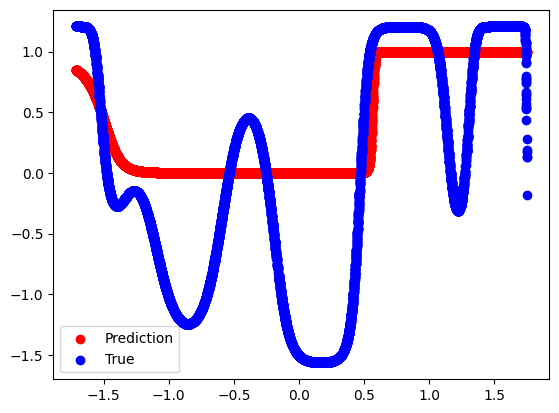

In [15]:
ea = Evolutionary_Algorithm(
    mutation_rate=0.7,
    crossover_rate=0.7,
    number_of_generations=300,
    population_size=50,
)
ea._generate_population([1, 10, 1])
ea._visualize_individual(
    ea.population[0],
    multimodal_large_train["x"],
    multimodal_large_train["y"],
)

architecture = [1, 5, 5, 1]
best_evaluation_in_iteration, best_solution_in_iteration = ea.optimize(
    multimodal_large_train["x"],
    multimodal_large_train["y"],
    architecture,
)
ea._visualize_individual(
    best_solution_in_iteration[-1],
    multimodal_large_train["x"],
    multimodal_large_train["y"],
)

In [ ]:
best_solution_in_iteration[-1].flatten_weights_and_biases()

array([ 47.49389771,  20.38823158,   4.5008131 ,   9.30855782,
       -19.72451177,  10.75760602,  -9.511696  ,   9.27372173,
        -4.65621245, -28.43906825,  -0.39258652,  23.02385354,
       -24.03832244,   7.38785126,  20.12981445,   5.2715123 ])